In [181]:
# 1. Import necessary libraries
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [182]:
# Load the dataset
stock_data = pd.read_csv('nike.csv')
stock_data = stock_data[['Close']].dropna().reset_index(drop=True)
close_prices = stock_data.reset_index()['Close']
# Reverse the chronological order of the data
reverse_close_prices = close_prices.loc[::-1].reset_index(drop=True)
stock_data_reverse = stock_data.loc[::-1].reset_index(drop=True)

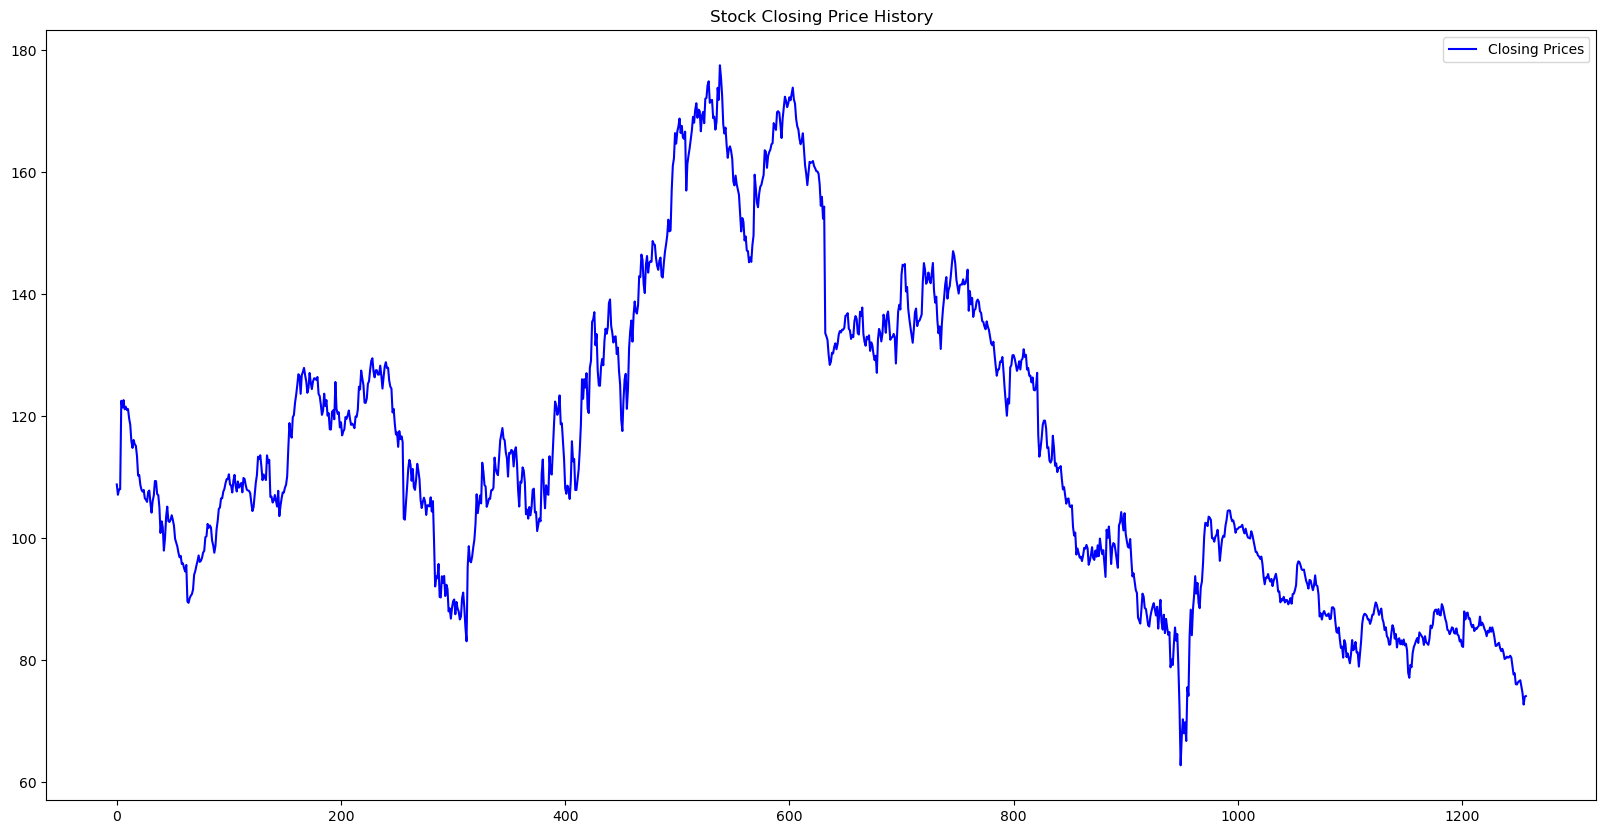

In [183]:
# Plot the historical closing prices
plt.figure(figsize=(20,10))
plt.plot(stock_data_reverse.index, stock_data_reverse['Close'], color='blue', label='Closing Prices')
plt.legend(loc='best')
plt.title('Stock Closing Price History')
plt.show()

In [184]:
# 3. Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close_prices = scaler.fit_transform(np.array(close_prices).reshape(-1, 1))

# Train-test(7-3)

In [185]:
# 4. Split the dataset into training and testing
train_size = int(0.7 * len(scaled_close_prices))
test_size = len(scaled_close_prices) - train_size

training_data = scaled_close_prices[:train_size]
testing_data = scaled_close_prices[train_size:]

In [186]:
# 5. Create input sequences and corresponding output for training and testing
def create_sequences(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        sequence = dataset[i:(i+look_back), 0]
        X.append(sequence)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# Initialize parameters
sequence_length = 30
X_train, y_train = create_sequences(training_data, sequence_length)
X_test, y_test = create_sequences(testing_data, sequence_length)
# Print the dimensions of the dataset
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(849, 30) (849,)
(347, 30) (347,)


In [187]:
# 6. Create an SVR model
svr_model = SVR()

# 7. Set up parameter ranges for grid search
C_range = np.logspace(-3, 3, 10)
gamma_range = np.logspace(-3, 3, 10)
kernel_range = ['rbf', 'linear', 'sigmoid']
param_grid = {'C': C_range, 'gamma': gamma_range, 'kernel': kernel_range}
# Set up the model with grid search
grid_search_model = GridSearchCV(svr_model, param_grid, refit=True, verbose=3, cv=5, scoring='neg_mean_squared_error')

In [188]:
# 8. Train the SVR model
grid_search_model.fit(X_train, y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
[CV 1/5] END .C=0.001, gamma=0.001, kernel=rbf;, score=-0.114 total time=   0.0s
[CV 2/5] END .C=0.001, gamma=0.001, kernel=rbf;, score=-0.080 total time=   0.0s
[CV 3/5] END .C=0.001, gamma=0.001, kernel=rbf;, score=-0.030 total time=   0.0s
[CV 4/5] END .C=0.001, gamma=0.001, kernel=rbf;, score=-0.150 total time=   0.0s
[CV 5/5] END .C=0.001, gamma=0.001, kernel=rbf;, score=-0.117 total time=   0.0s
[CV 1/5] END C=0.001, gamma=0.001, kernel=linear;, score=-0.009 total time=   0.0s
[CV 2/5] END C=0.001, gamma=0.001, kernel=linear;, score=-0.008 total time=   0.0s
[CV 3/5] END C=0.001, gamma=0.001, kernel=linear;, score=-0.002 total time=   0.0s
[CV 4/5] END C=0.001, gamma=0.001, kernel=linear;, score=-0.012 total time=   0.0s
[CV 5/5] END C=0.001, gamma=0.001, kernel=linear;, score=-0.008 total time=   0.0s
[CV 1/5] END C=0.001, gamma=0.001, kernel=sigmoid;, score=-0.116 total time=   0.0s
[CV 2/5] END C=0.001, gamma=0.00

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]),
                         'kernel': ['rbf', 'linear', 'sigmoid']},
             scoring='neg_mean_squared_error', verbose=3)

In [189]:
# 9. Predict the test data
y_pred = grid_search_model.predict(X_test)

# 10. Evaluate the model using MAE and RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(np.mean((y_pred - y_test)**2))
mape = mean_absolute_percentage_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Display the metrics
print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Mean Absolute Error (MAE):', mae)

Mean Squared Error (MSE): 0.0007803759112033615
Root Mean Squared Error (RMSE): 0.02793520916698784
Mean Absolute Percentage Error (MAPE): 0.05726676108232242
Mean Absolute Error (MAE): 0.021692523260543654


In [190]:
# Create an array to store the next 30 days' predictions
future_predictions = []

# Create a loop to predict the next 30 days
for i in range(future_days):
    # Predict the next day using the last available data
    next_day_prediction = grid_search_model.predict(last_30_days_data)[0]
    
    # Append the prediction to the future predictions array
    future_predictions.append(next_day_prediction)
    
    # Update last_30_days_data by removing the first element and adding the new prediction
    last_30_days_data = np.append(last_30_days_data[:, 1:], [[next_day_prediction]], axis=1)
    last_30_days_data = last_30_days_data.reshape((1, sequence_length))
# Convert future predictions to a NumPy array
future_predictions = np.array(future_predictions)

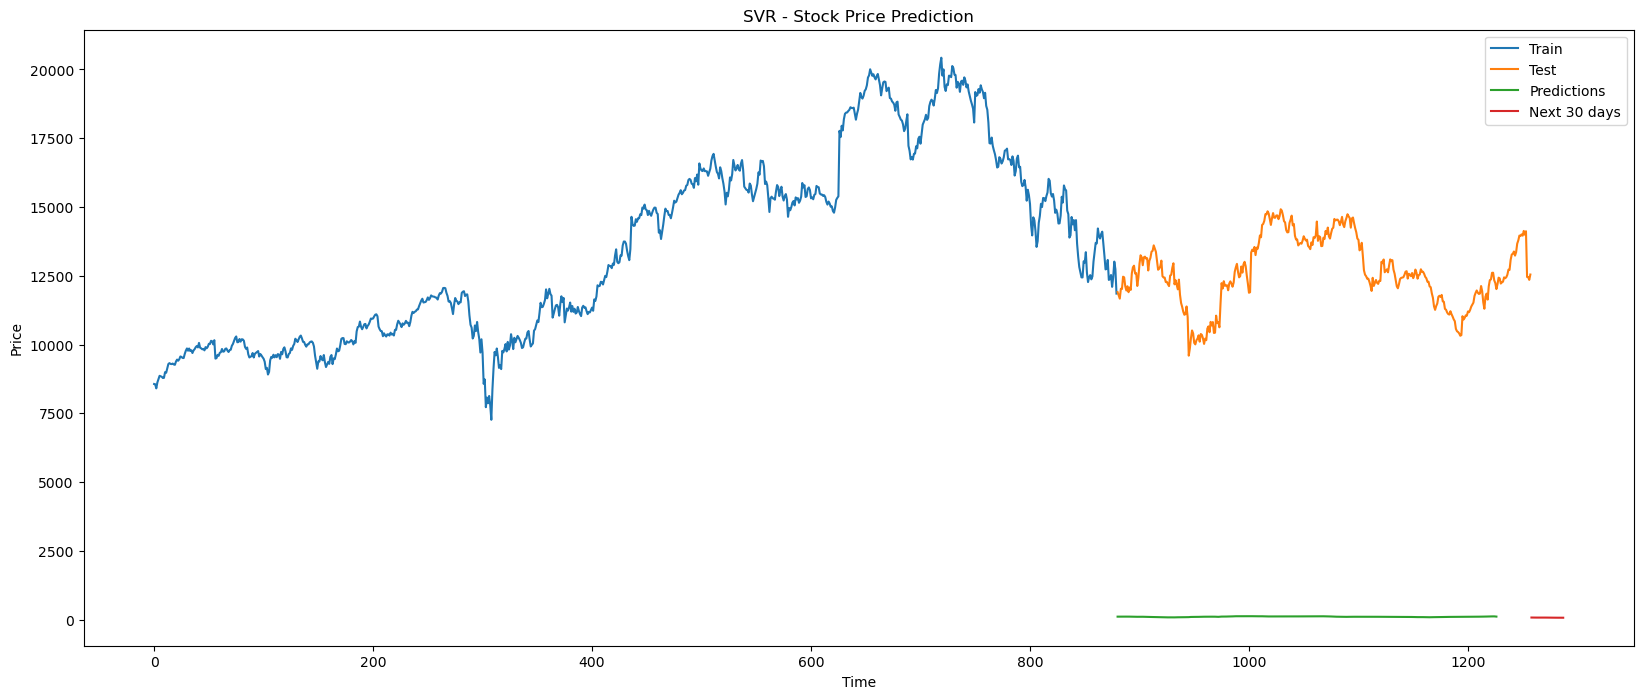

In [191]:
plt.figure(figsize=(20, 8))

# Plotting the training data
train_data_index = pd.RangeIndex(start=0, stop=len(train_data), step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

# Plotting the test data
test_data_index = pd.RangeIndex(start=len(train_data), stop=len(train_data) + len(test_data), step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

# Plotting the test predictions
test_pred_index = pd.RangeIndex(start=len(train_data), stop=len(train_data) + len(y_pred), step=1)
plt.plot(test_pred_index, scaler.inverse_transform(y_pred.reshape(-1, 1)), label='Test Predictions')

# Plotting the future predictions
future_pred_index = pd.RangeIndex(start=len(train_data) + len(test_data), stop=len(train_data) + len(test_data) + len(future_predictions), step=1)
plt.plot(future_pred_index, scaler.inverse_transform(future_predictions.reshape(-1, 1)), label='Next 30 Days Predictions')

plt.xlabel('Time')
plt.ylabel('Price')
plt.title('SVR - Stock Price Prediction')
plt.legend(['Train', 'Test', 'Predictions', 'Next 30 days'])
plt.show()

# Train-test(8-2)

In [192]:
# 4. Split the dataset into training and testing
train_size = int(0.8 * len(scaled_close_prices))
test_size = len(scaled_close_prices) - train_size

training_data = scaled_close_prices[:train_size]
testing_data = scaled_close_prices[train_size:]

In [193]:
def create_sequences(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        sequence = dataset[i:(i+look_back), 0]
        X.append(sequence)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# Initialize parameters
sequence_length = 30
X_train, y_train = create_sequences(training_data, sequence_length)
X_test, y_test = create_sequences(testing_data, sequence_length)
# Print the dimensions of the dataset
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(975, 30) (975,)
(221, 30) (221,)


In [194]:
# 6. Create an SVR model
svr_model = SVR()

# 7. Set up parameter ranges for grid search
C_range = np.logspace(-3, 3, 10)
gamma_range = np.logspace(-3, 3, 10)
kernel_range = ['rbf', 'linear', 'sigmoid']
param_grid = {'C': C_range, 'gamma': gamma_range, 'kernel': kernel_range}
# Set up the model with grid search
grid_search_model = GridSearchCV(svr_model, param_grid, refit=True, verbose=3, cv=5, scoring='neg_mean_squared_error')

In [195]:
# 8. Train the SVR model
grid_search_model.fit(X_train, y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
[CV 1/5] END .C=0.001, gamma=0.001, kernel=rbf;, score=-0.094 total time=   0.0s
[CV 2/5] END .C=0.001, gamma=0.001, kernel=rbf;, score=-0.057 total time=   0.0s
[CV 3/5] END .C=0.001, gamma=0.001, kernel=rbf;, score=-0.072 total time=   0.0s
[CV 4/5] END .C=0.001, gamma=0.001, kernel=rbf;, score=-0.227 total time=   0.0s
[CV 5/5] END .C=0.001, gamma=0.001, kernel=rbf;, score=-0.013 total time=   0.0s
[CV 1/5] END C=0.001, gamma=0.001, kernel=linear;, score=-0.005 total time=   0.0s
[CV 2/5] END C=0.001, gamma=0.001, kernel=linear;, score=-0.005 total time=   0.0s
[CV 3/5] END C=0.001, gamma=0.001, kernel=linear;, score=-0.002 total time=   0.0s
[CV 4/5] END C=0.001, gamma=0.001, kernel=linear;, score=-0.026 total time=   0.0s
[CV 5/5] END C=0.001, gamma=0.001, kernel=linear;, score=-0.006 total time=   0.0s
[CV 1/5] END C=0.001, gamma=0.001, kernel=sigmoid;, score=-0.095 total time=   0.0s
[CV 2/5] END C=0.001, gamma=0.00

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]),
                         'kernel': ['rbf', 'linear', 'sigmoid']},
             scoring='neg_mean_squared_error', verbose=3)

In [196]:
# 9. Predict the test data
y_pred = grid_search_model.predict(X_test)

# 10. Evaluate the model using MAE and RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(np.mean((y_pred - y_test)**2))
mape = mean_absolute_percentage_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Display the metrics
print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Mean Absolute Error (MAE):', mae)

Mean Squared Error (MSE): 0.0005664553524669244
Root Mean Squared Error (RMSE): 0.023800322528632345
Mean Absolute Percentage Error (MAPE): 0.04595096365130406
Mean Absolute Error (MAE): 0.018357107819248146


In [197]:
# Create an array to store the next 30 days' predictions
future_predictions = []

# Create a loop to predict the next 30 days
for i in range(future_days):
    # Predict the next day using the last available data
    next_day_prediction = grid_search_model.predict(last_30_days_data)[0]
    
    # Append the prediction to the future predictions array
    future_predictions.append(next_day_prediction)
    
    # Update last_30_days_data by removing the first element and adding the new prediction
    last_30_days_data = np.append(last_30_days_data[:, 1:], [[next_day_prediction]], axis=1)
    last_30_days_data = last_30_days_data.reshape((1, sequence_length))
# Convert future predictions to a NumPy array
future_predictions = np.array(future_predictions)

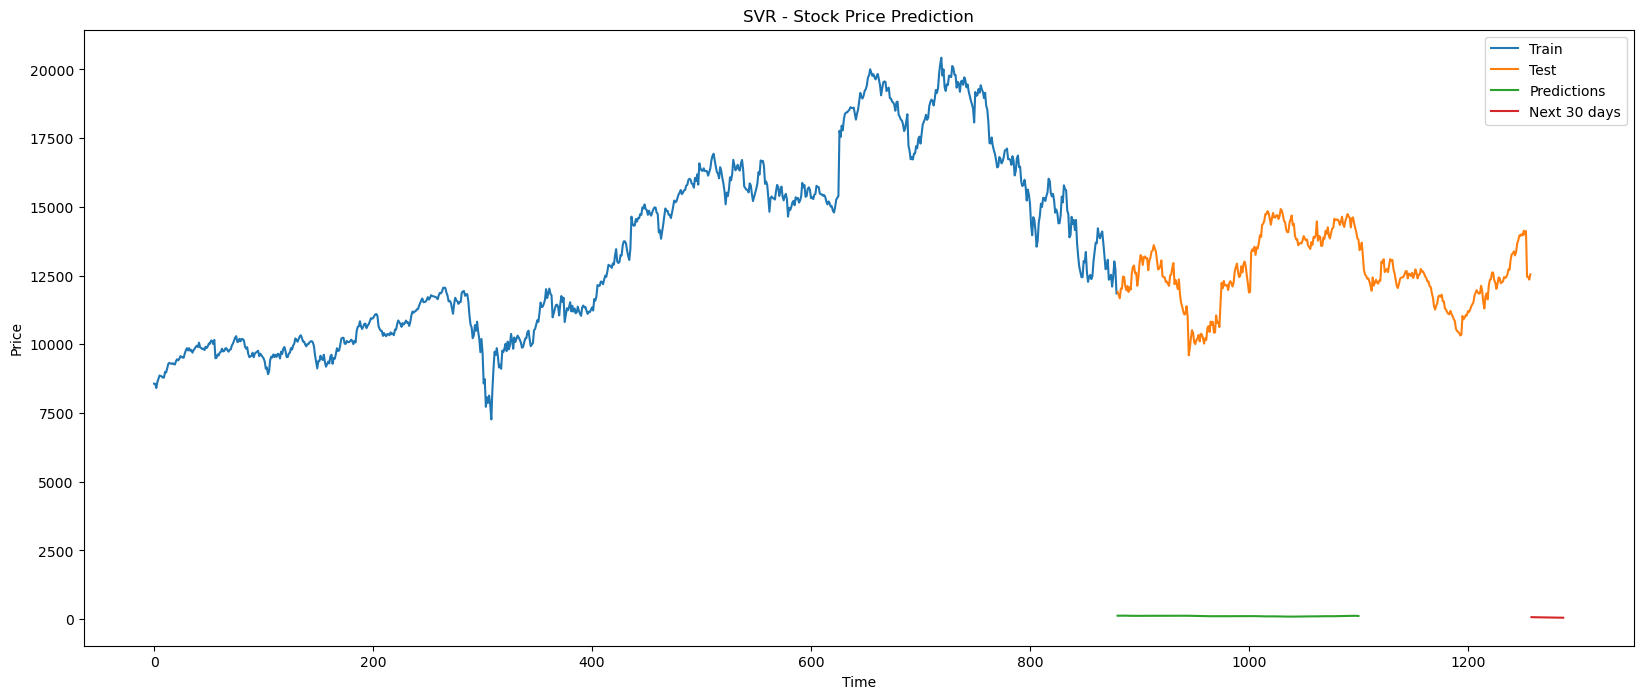

In [198]:
plt.figure(figsize=(20, 8))

# Plotting the training data
train_data_index = pd.RangeIndex(start=0, stop=len(train_data), step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

# Plotting the test data
test_data_index = pd.RangeIndex(start=len(train_data), stop=len(train_data) + len(test_data), step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

# Plotting the test predictions
test_pred_index = pd.RangeIndex(start=len(train_data), stop=len(train_data) + len(y_pred), step=1)
plt.plot(test_pred_index, scaler.inverse_transform(y_pred.reshape(-1, 1)), label='Test Predictions')

# Plotting the future predictions
future_pred_index = pd.RangeIndex(start=len(train_data) + len(test_data), stop=len(train_data) + len(test_data) + len(future_predictions), step=1)
plt.plot(future_pred_index, scaler.inverse_transform(future_predictions.reshape(-1, 1)), label='Next 30 Days Predictions')

plt.xlabel('Time')
plt.ylabel('Price')
plt.title('SVR - Stock Price Prediction')
plt.legend(['Train', 'Test', 'Predictions', 'Next 30 days'])
plt.show()

# Train-test(9-1)

In [199]:
# 4. Split the dataset into training and testing
train_size = int(0.9 * len(scaled_close_prices))
test_size = len(scaled_close_prices) - train_size

training_data = scaled_close_prices[:train_size]
testing_data = scaled_close_prices[train_size:]

In [200]:
def create_sequences(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        sequence = dataset[i:(i+look_back), 0]
        X.append(sequence)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# Initialize parameters
sequence_length = 30
X_train, y_train = create_sequences(training_data, sequence_length)
X_test, y_test = create_sequences(testing_data, sequence_length)
# Print the dimensions of the dataset
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1101, 30) (1101,)
(95, 30) (95,)


In [201]:
# 6. Create an SVR model
svr_model = SVR()

# 7. Set up parameter ranges for grid search
C_range = np.logspace(-3, 3, 10)
gamma_range = np.logspace(-3, 3, 10)
kernel_range = ['rbf', 'linear', 'sigmoid']
param_grid = {'C': C_range, 'gamma': gamma_range, 'kernel': kernel_range}
# Set up the model with grid search
grid_search_model = GridSearchCV(svr_model, param_grid, refit=True, verbose=3, cv=5, scoring='neg_mean_squared_error')

In [202]:
# 8. Train the SVR model
grid_search_model.fit(X_train, y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
[CV 1/5] END .C=0.001, gamma=0.001, kernel=rbf;, score=-0.090 total time=   0.0s
[CV 2/5] END .C=0.001, gamma=0.001, kernel=rbf;, score=-0.042 total time=   0.0s
[CV 3/5] END .C=0.001, gamma=0.001, kernel=rbf;, score=-0.122 total time=   0.0s
[CV 4/5] END .C=0.001, gamma=0.001, kernel=rbf;, score=-0.099 total time=   0.0s
[CV 5/5] END .C=0.001, gamma=0.001, kernel=rbf;, score=-0.011 total time=   0.0s
[CV 1/5] END C=0.001, gamma=0.001, kernel=linear;, score=-0.004 total time=   0.0s
[CV 2/5] END C=0.001, gamma=0.001, kernel=linear;, score=-0.005 total time=   0.0s
[CV 3/5] END C=0.001, gamma=0.001, kernel=linear;, score=-0.010 total time=   0.0s
[CV 4/5] END C=0.001, gamma=0.001, kernel=linear;, score=-0.007 total time=   0.0s
[CV 5/5] END C=0.001, gamma=0.001, kernel=linear;, score=-0.005 total time=   0.0s
[CV 1/5] END C=0.001, gamma=0.001, kernel=sigmoid;, score=-0.091 total time=   0.0s
[CV 2/5] END C=0.001, gamma=0.00

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]),
                         'kernel': ['rbf', 'linear', 'sigmoid']},
             scoring='neg_mean_squared_error', verbose=3)

In [203]:
# 9. Predict the test data
y_pred = grid_search_model.predict(X_test)

# 10. Evaluate the model using MAE and RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(np.mean((y_pred - y_test)**2))
mape = mean_absolute_percentage_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Display the metrics
print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Mean Absolute Error (MAE):', mae)

Mean Squared Error (MSE): 0.0005291666273496993
Root Mean Squared Error (RMSE): 0.02300362204848835
Mean Absolute Percentage Error (MAPE): 0.04835690850599697
Mean Absolute Error (MAE): 0.017264885810547595


In [204]:
# Create an array to store the next 30 days' predictions
future_predictions = []

# Create a loop to predict the next 30 days
for i in range(future_days):
    # Predict the next day using the last available data
    next_day_prediction = grid_search_model.predict(last_30_days_data)[0]
    
    # Append the prediction to the future predictions array
    future_predictions.append(next_day_prediction)
    
    # Update last_30_days_data by removing the first element and adding the new prediction
    last_30_days_data = np.append(last_30_days_data[:, 1:], [[next_day_prediction]], axis=1)
    last_30_days_data = last_30_days_data.reshape((1, sequence_length))
# Convert future predictions to a NumPy array
future_predictions = np.array(future_predictions)

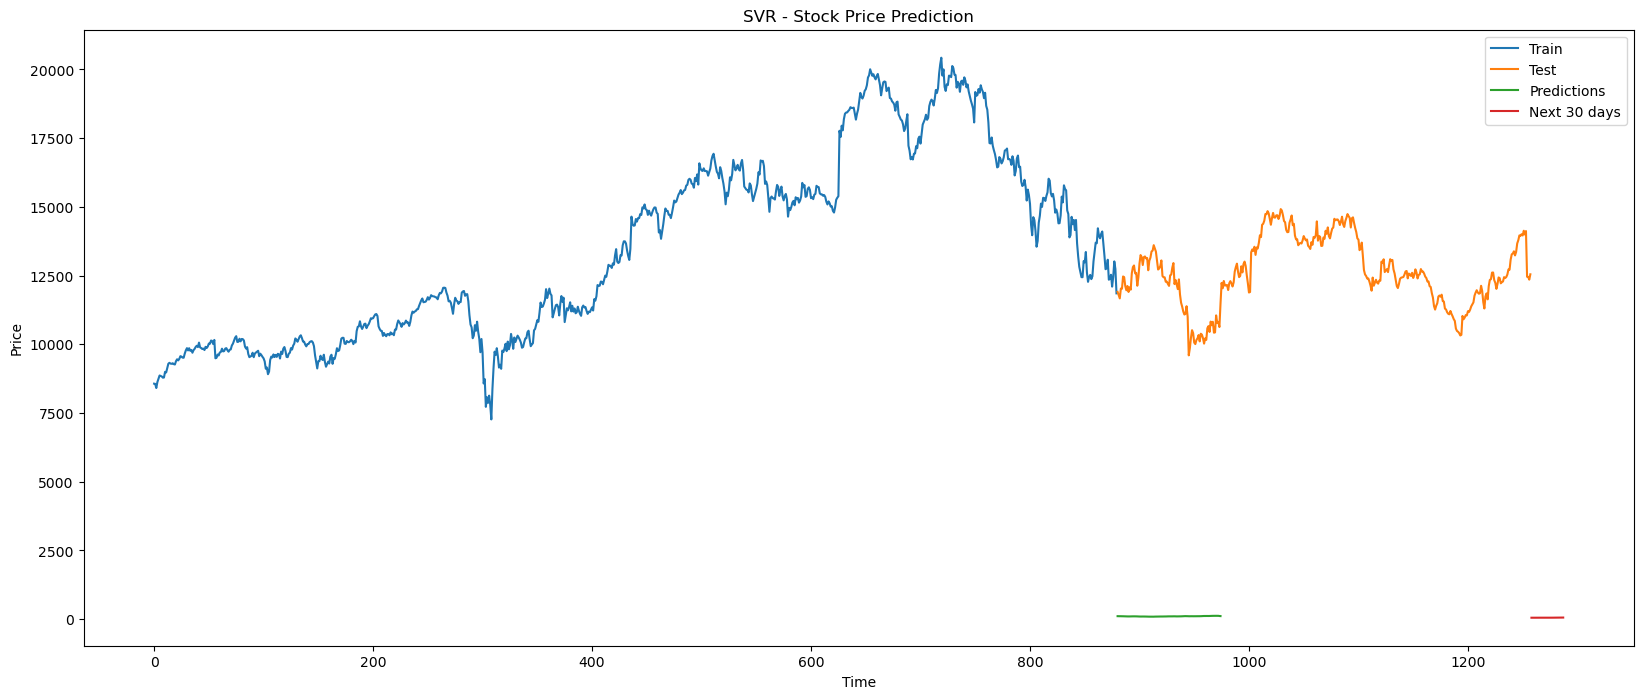

In [205]:
plt.figure(figsize=(20, 8))

# Plotting the training data
train_data_index = pd.RangeIndex(start=0, stop=len(train_data), step=1)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

# Plotting the test data
test_data_index = pd.RangeIndex(start=len(train_data), stop=len(train_data) + len(test_data), step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

# Plotting the test predictions
test_pred_index = pd.RangeIndex(start=len(train_data), stop=len(train_data) + len(y_pred), step=1)
plt.plot(test_pred_index, scaler.inverse_transform(y_pred.reshape(-1, 1)), label='Test Predictions')

# Plotting the future predictions
future_pred_index = pd.RangeIndex(start=len(train_data) + len(test_data), stop=len(train_data) + len(test_data) + len(future_predictions), step=1)
plt.plot(future_pred_index, scaler.inverse_transform(future_predictions.reshape(-1, 1)), label='Next 30 Days Predictions')

plt.xlabel('Time')
plt.ylabel('Price')
plt.title('SVR - Stock Price Prediction')
plt.legend(['Train', 'Test', 'Predictions', 'Next 30 days'])
plt.show()